## Numerical simulation of the dynamics of the optical tweezers

The motion of the bead controlled by the optical tweezers is described by the differential equation
$$
\frac{\mathrm dx(t)}{\mathrm dt} = -k x(t) + \eta(t),
$$

with $k$ the stiffness of the harmonic trap potential and $\eta(t) = \frac{\mathrm dB}{\mathrm dt}$ white noise. First we define the function $\eta$ and set initial parameters.

In [226]:
# Brownian noise
brownian = function(sigma){
    rnorm(1, sd=sigma)
}

# Method to use. 1 = Euler, 2 = AR(1)
method = 1

k = c(110, 120) # Stiffness of the harmonic potential in x, y

# Initial points x0, y0 for the particle
# Because the process is Markov, we want to start from a position created with the equilibrium state variance.
# If this is correct, the variance of the resulting coordinates should be the same.
x0 = rnorm(1, sd=sqrt(1/(2*k[1])) )
y0 = rnorm(1, sd=sqrt(1/(2*k[2])) )

fps = 15000

startt = 0 # Starting time
endt = 10 # End time

# Multiply the frequency for the dynamics simulator (-> discard 1/freqmult of the points in the end)
freqmult = 10

nsteps = (endt-startt)*fps*freqmult
dt = (endt - startt)/nsteps
steps = matrix(,nsteps,2)
sample = seq(1,nsteps,freqmult)
list(x0 = x0, y0=y0, steps = nsteps, timestep=dt, points = length(sample))

$x0
[1] 0.01520798

$y0
[1] -0.02679884

$steps
[1] 1500000

$timestep
[1] 6.666667e-06

$points
[1] 150000

We can use the Euler method to solve the differential equation iteratively for the given number of steps:
$$
\begin{align}
\Delta x_{n-1} &= -k x_{n-1} + \Delta B \\
x_n &= x_{n-1} + \Delta x_{n-1}
\end{align}
$$

or we can directly use the discrete AR(1) model:

$$
\begin{align}
x_{n+1} &= \alpha x_n + z_n, \\
\alpha &= e^{-k \Delta t}, \\
\mathrm{var}(z_n) &= (1-\alpha^2) \mathrm{var}(x_n)
\end{align}
$$

In [228]:
steps[1,] = c(x0, y0)

for(i in 2:nsteps){
    # Euler
    if(method == 1){
    delta = -k * steps[i-1,] * dt + c(brownian(sqrt(dt)), brownian(sqrt(dt)))
    steps[i,] = steps[i-1,] + delta
    }
    else
    {
    # AR(1)
    steps[i,] = alpha * steps[i-1,]
    }
}

ERROR: Error: object 'method' not found


In [214]:
freq = fps*2*pi
traj = ts(steps[sample,], frequency = freq)
xvar = var(traj[,1])
yvar = var(traj[,2])
list(xmean = mean(traj[,1]), xvariance= xvar,
     ymean = mean(traj[,2]), yvariance=yvar,
     xvarratio = xvar*(2*k[1]), yvarratio = yvar*(2*k[1])) # These should be close to 1

$xmean
[1] 1.380109e-05

$xvariance
[1] 0.004575119

$ymean
[1] 0.005219418

$yvariance
[1] 0.004053273

$xvarratio
[1] 1.006526

$yvarratio
[1] 0.89172

An estimate for the stiffness $k$ should be obtainable from the variance in the coordinates, since
$$
k \sim \frac{k_b T}{2\sigma^2}
$$

In [215]:
#m_per_px = 9*10^(-9)
m_per_px = 10^(-7)
kb = 1.38064852 * 10^(-23) # Boltzmann constant
T = 293 # Ambient temperature
r = 3*10^(-6) # Radius of the bead
eta = 1^(-3)
beta = 6*pi*r*eta

kx = (kb*T)/(2*xvar*m_per_px^2)
ky = (kb*T)/(2*yvar*m_per_px^2)

list(kx = kx, ky = ky,
     xkratio = beta*k[1]/kx,
     ykratio = beta*k[2]/ky
     )

$kx
[1] 4.420978e-05

$ky
[1] 4.990165e-05

$xkratio
[1] 140.7009

$ykratio
[1] 135.9843

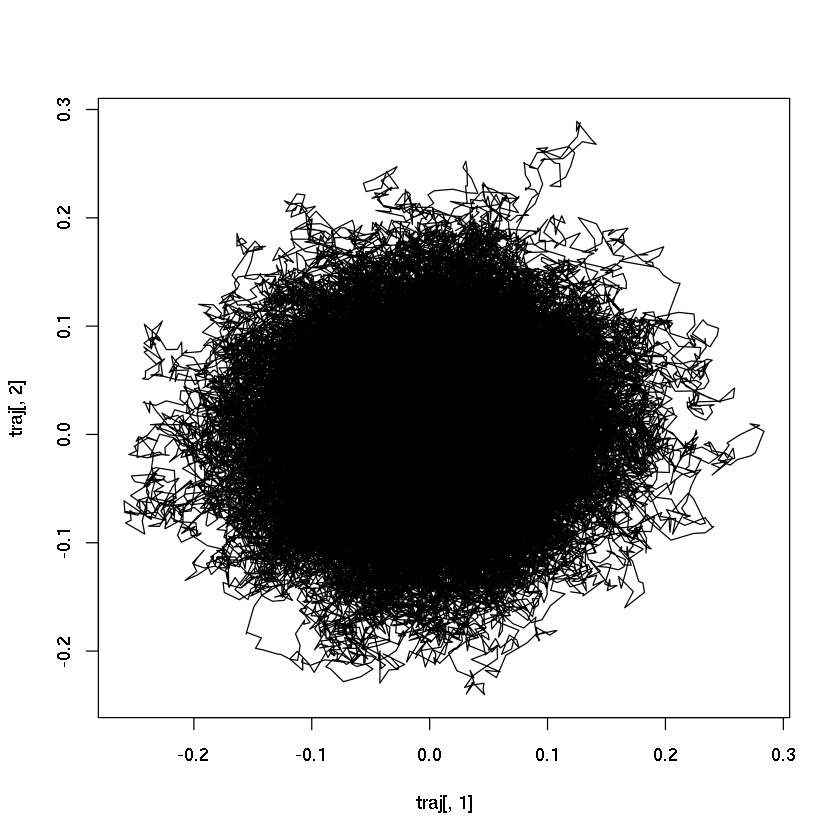

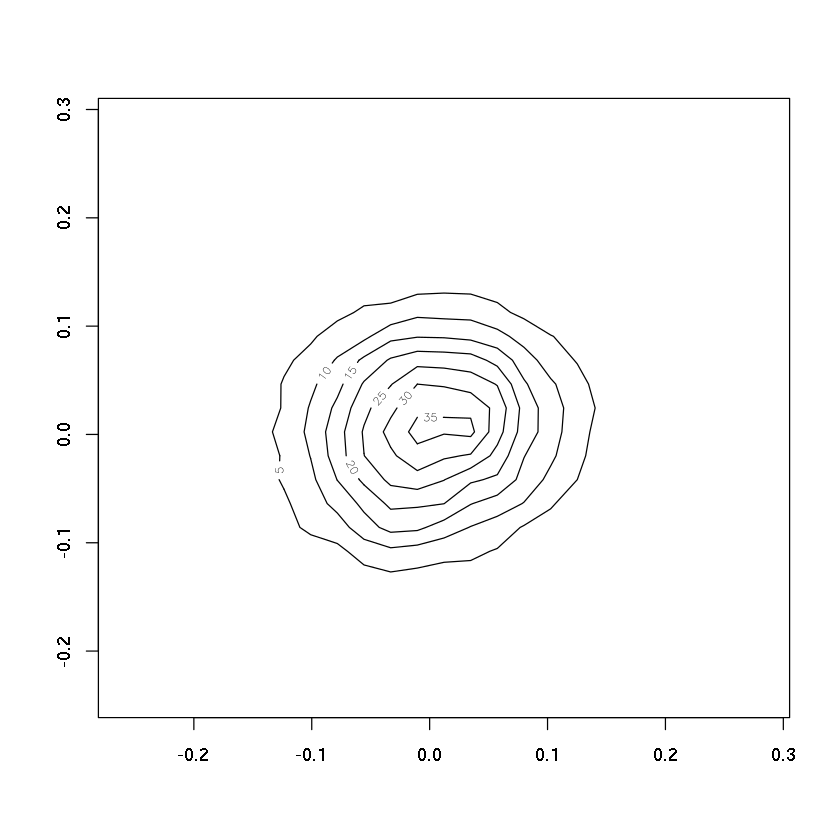

In [216]:
plot(traj[,1], traj[,2], type='l')
library('MASS')
contour(kde2d(traj[,1], traj[,2]))

Warning message:
In xy.coords(x, y, xlabel, ylabel, log): 285 y values <= 0 omitted from logarithmic plotWarning message:
In xy.coords(x, y, xlabel, ylabel, log): 68 y values <= 0 omitted from logarithmic plot

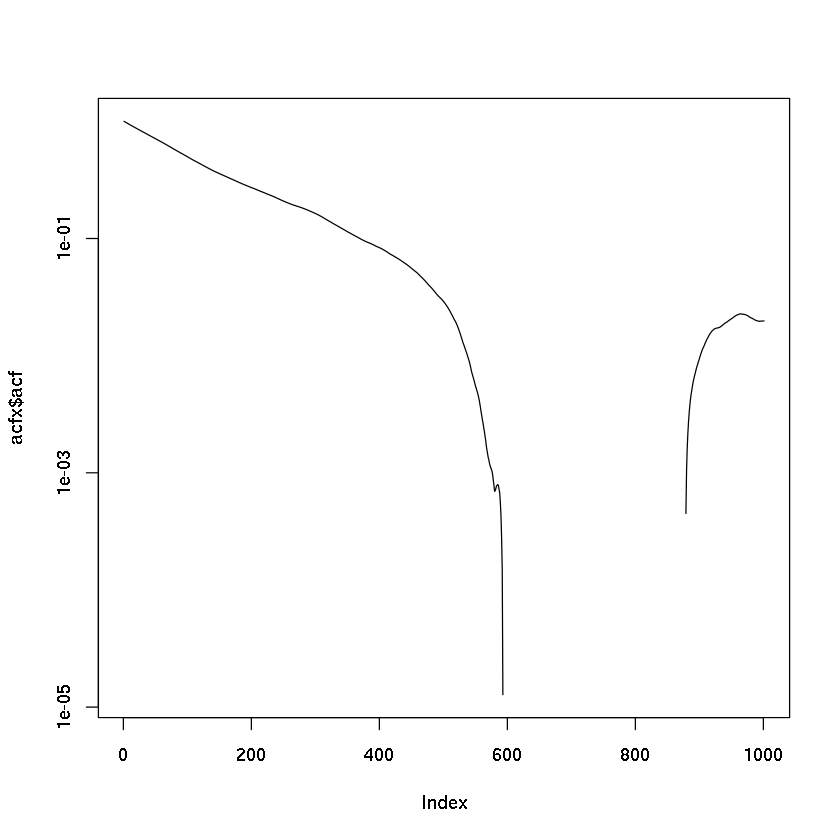

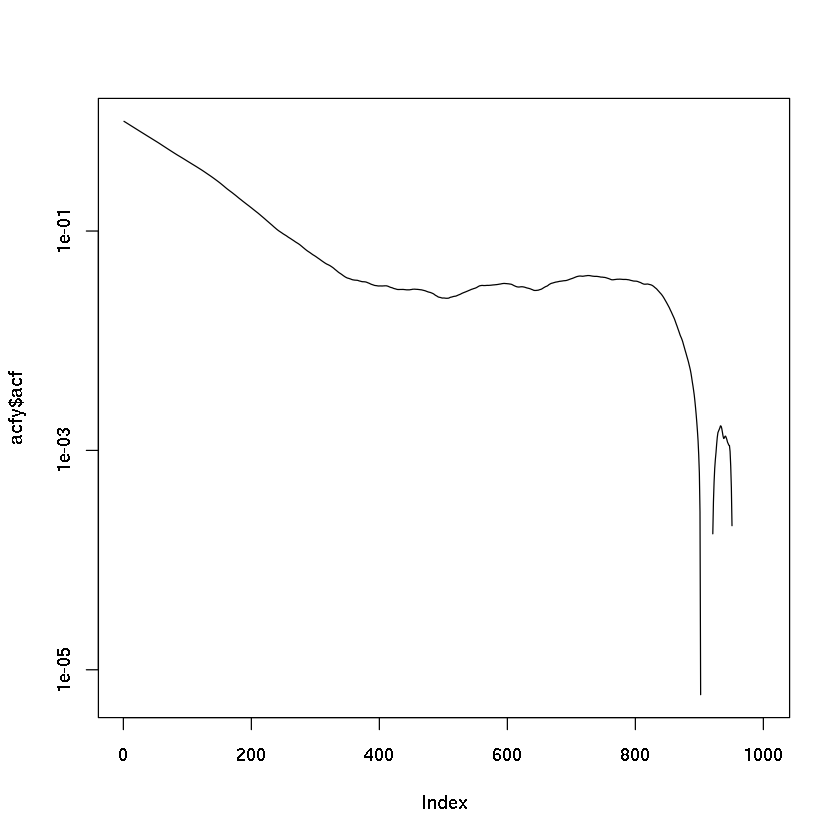

In [217]:
acfx = acf(traj[,1], lag=1000, plot=FALSE)
acfy = acf(traj[,2], lag=1000, plot=FALSE)
plot(acfx$acf, log='y', type='l')
plot(acfy$acf, log='y', type='l')

In [218]:
linpart = 1:100

ax = seq(0, (length(linpart)-1)*(1/fps), 1/fps)
logacfx = log(acfx$acf[linpart])
fitx = lm(logacfx ~ ax)
fitx$coefficients

logacfy = log(acfy$acf[linpart])
fity = lm(logacfy ~ ax)
fity$coefficients

(Intercept)            ax 
-3.933719e-04 -1.047385e+02

(Intercept)            ax 
 1.660776e-03 -1.270104e+02

In [219]:
kpar = c(16,16)
sx = spectrum(traj[,1], plot=FALSE, spans=kpar)
sy = spectrum(traj[,2], plot=FALSE, spans=kpar)

# Initial values
sigma0 = 1
k0 = 0.1

# Extract values to fit to
specx = sx$spec
freqx = sx$freq

# Fit the fourier transform of acov(x) (acov(y))
fitx = nls(specx ~ (sigma^2)/(freqx^2 + k^2),
                 start = list(sigma = sigma0, k = k0))
fitx

specy = sy$spec
freqy = sy$freq

fity = nls(specy ~ (sigma^2)/(freqx^2 + k^2),
                 start = list(sigma = sigma0, k = k0))
fity

Nonlinear regression model
  model: specx ~ (sigma^2)/(freqx^2 + k^2)
   data: parent.frame()
   sigma        k 
  0.3772 101.6738 
 residual sum-of-squares: 7.376e-10

Number of iterations to convergence: 17 
Achieved convergence tolerance: 2.775e-07

Nonlinear regression model
  model: specy ~ (sigma^2)/(freqx^2 + k^2)
   data: parent.frame()
   sigma        k 
  0.4232 135.1015 
 residual sum-of-squares: 6.277e-10

Number of iterations to convergence: 18 
Achieved convergence tolerance: 1.151e-06

$xkratio
        k 
0.9243075 

$ykratio
       k 
1.125846

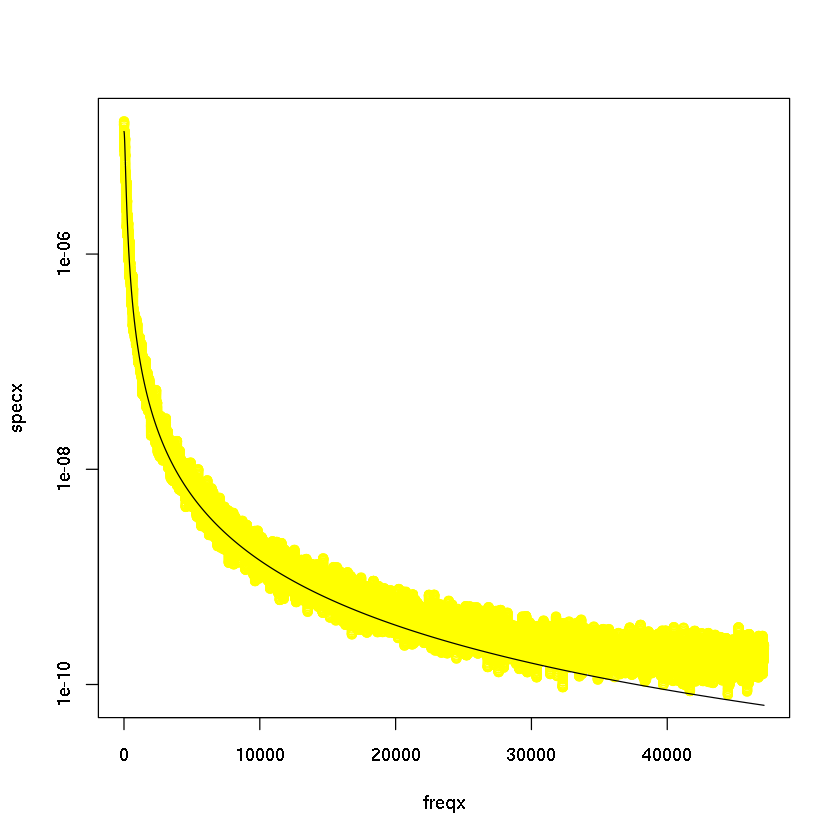

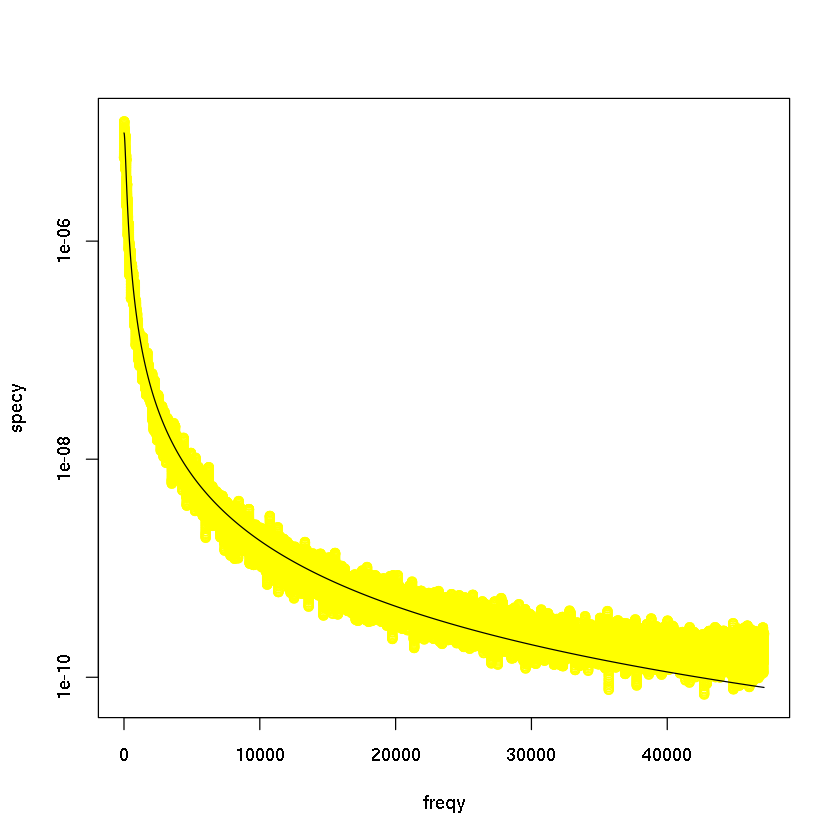

In [221]:
coefsx = coef(fitx)
coefsy = coef(fity)
list(xkratio = coefsx['k']/k[1], ykratio = coefsy['k']/k[2])

plot(freqx, specx, col='yellow', log='y')
lines(freqx, (coefsx['sigma']^2)/(freqx^2+coefsx['k']^2), type='l')

plot(freqy, specy, col='yellow', log='y')
lines(freqy, (coefsy['sigma']^2)/(freqy^2+coefsy['k']^2), type='l')